<table class="table table-bordered">
    <tr>
        <th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Problem 2 - Sentiment Analysis Model  (Group)</h2><h3>AY2025 Semester</h3></th>
    </tr>
</table>

In [ ]:
# Import the Required Packages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout,GRU
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input
from sklearn.utils import class_weight
from tensorflow.keras import models
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2

import random
import numpy as np
import tensorflow as tf

# Set random seed for reproducibility
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


## Step 1 – Data Loading and Processing (Group)

### 1.1 Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/assg/teams_reviews.csv')
df.head()

Mounted at /content/drive


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,aa395e07-0b0c-4425-8bcf-2a60e8e5abdb,P,https://play-lh.googleusercontent.com/a/ACg8oc...,"literally the worse, they make it impossible t...",1,2,9.22.1 build 3 62948,2025-07-04 07:36:39,NaN,NaN,9.22.1 build 3 62948
1,9a8bc879-b223-4dda-acc0-7dda595bc622,Kory BlackBuzzardBlvdMusic Knight,https://play-lh.googleusercontent.com/a-/ALV-U...,Take away the stupid household feature. someth...,3,4,9.21.0 build 5 62896,2025-06-30 04:19:52,NaN,NaN,9.21.0 build 5 62896
2,f168ab70-8de4-4d9c-86a6-fa9644498973,Paweł Ciechański,https://play-lh.googleusercontent.com/a-/ALV-U...,"was banned from service for no reason, it does...",1,11,9.20.0 build 8 62860,2025-06-28 20:02:58,NaN,NaN,9.20.0 build 8 62860
3,45805207-fc04-464c-bee6-dc976cb8fdc2,Afolabi Oladipo,https://play-lh.googleusercontent.com/a-/ALV-U...,excellent,5,0,9.7.1 build 9 62328,2025-06-26 20:56:10,NaN,NaN,9.7.1 build 9 62328
4,4a6e50d5-9049-401b-a049-34c61d055a2e,Debi Alfred,https://play-lh.googleusercontent.com/a/ACg8oc...,I love the movie in this app😍😍😍❤️ I it interes...,5,0,9.16.0 build 6 62648,2025-06-26 20:56:00,NaN,NaN,9.16.0 build 6 62648


In [ ]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['cleaned_content'] = df['content'].apply(clean_text)

In [ ]:
def label_sentiment(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['label'] = df['score'].apply(label_sentiment)
y = df['label'].values

In [ ]:


# Step 1: Tokenize and Pad
max_words = 10000
maxlen = 150

tokenizer = Tokenizer(num_words=max_words) # num_words: the maximum number of words to keep, based on word frequency.
tokenizer.fit_on_texts(df['cleaned_content'])
sequences = tokenizer.texts_to_sequences(df['cleaned_content'])

X = pad_sequences(sequences, maxlen=maxlen)
#y = df['label'].values
df['label'] = df['score'] - 1
y = df['label'].values


### 1.2 Data Processing


### 1.3 Data Sampling

In [ ]:
# Split the X & y into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y_train
)

# Convert to dict for Keras
class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(0.47215432189662787), 1: np.float64(3.3553788195897867), 2: np.float64(3.5127081507449605), 3: np.float64(2.99775617053104), 4: np.float64(0.5087101380295097)}


# Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student)

## Comparing RNN models and Optimizers

### Comparing LSTM and GRU

LSTM with RMSprop

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
#Decreased learning rate of RMSprop
model = models.Sequential()
model.add(Embedding(10000, 16, input_length=maxlen))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=3,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 93s 179ms/step - accuracy: 0.6172 - loss: 0.9740 - val_accuracy: 0.7025 - val_loss: 0.7256
Epoch 2/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 93s 186ms/step - accuracy: 0.7300 - loss: 0.7947 - val_accuracy: 0.7449 - val_loss: 0.6578
Epoch 3/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 135s 172ms/step - accuracy: 0.7453 - loss: 0.7459 - val_accuracy: 0.7535 - val_loss: 0.6353


GRU with RMSprop

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
#Decreased learning rate of RMSprop
model = models.Sequential()
model.add(Embedding(10000, 16, input_length=maxlen))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=3,
    class_weight=class_weights
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 113s 219ms/step - accuracy: 0.6750 - loss: 0.9331 - val_accuracy: 0.7174 - val_loss: 0.6929
Epoch 2/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 105s 210ms/step - accuracy: 0.7362 - loss: 0.7750 - val_accuracy: 0.7383 - val_loss: 0.6674
Epoch 3/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 109s 218ms/step - accuracy: 0.7541 - loss: 0.7360 - val_accuracy: 0.7512 - val_loss: 0.6427


### Comparing Adam and RMSprop

LSTM with Adam

In [ ]:
model = models.Sequential()
model.add(Embedding(10000, 16, input_length=maxlen))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=3,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 94s 179ms/step - accuracy: 0.6070 - loss: 0.9446 - val_accuracy: 0.7859 - val_loss: 0.6106
Epoch 2/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 140s 174ms/step - accuracy: 0.7569 - loss: 0.7319 - val_accuracy: 0.7836 - val_loss: 0.5971
Epoch 3/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 139s 168ms/step - accuracy: 0.7747 - loss: 0.6748 - val_accuracy: 0.7849 - val_loss: 0.5956


Overall,it shows that LSTM and Adam is the better combination.

## Baseline Model

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

model = models.Sequential()
model.add(Embedding(10000, 16, input_length=maxlen))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=15,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6167 - loss: 0.9470 - val_accuracy: 0.7665 - val_loss: 0.6243
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7482 - loss: 0.7307 - val_accuracy: 0.7726 - val_loss: 0.6039
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7716 - loss: 0.6766 - val_accuracy: 0.7791 - val_loss: 0.5975
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7856 - loss: 0.6390 - val_accuracy: 0.7934 - val_loss: 0.5846
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7926 - loss: 0.6136 - val_accuracy: 0.7907 - val_loss: 0.5966
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8061 - loss: 0.5827 - val_accuracy: 0.7992 - val_loss: 0.5859
Epoch 7/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8143 - loss: 0.5628 - val_accuracy: 0.7963 - val_loss: 0.5959
Epoch 8/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8230 - loss: 0.5419 - val_

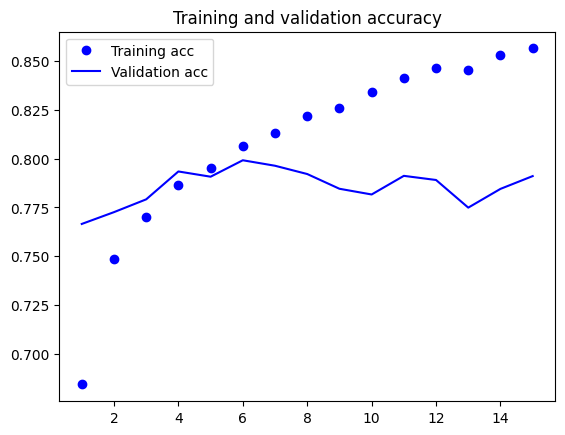

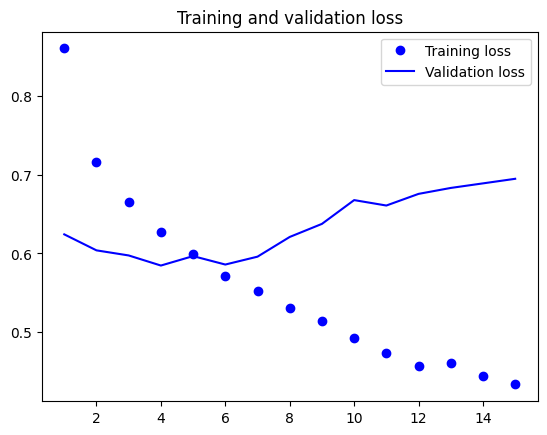

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
model.save('/content/drive/MyDrive/baseline_text_model.h5')

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model 1 (Added Regulaization and dropout)

In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words, output_dim=100))
model.add(LSTM(32, kernel_regularizer=l2(0.005))) #added regularization
model.add(Dropout(0.5)) #added Dropout
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.005))) #added one more dense layer
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,603 (3.88 MB)

 Trainable params: 1,017,603 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.5443 - loss: 1.6279 - val_acc: 0.6679 - val_loss: 1.2857
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.5920 - loss: 1.2915 - val_acc: 0.6896 - val_loss: 1.0827
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.6200 - loss: 1.1266 - val_acc: 0.7398 - val_loss: 0.9187
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.6906 - loss: 1.0177 - val_acc: 0.7713 - val_loss: 0.8104
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.7151 - loss: 0.9632 - val_acc: 0.7811 - val_loss: 0.7642
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - acc: 0.7347 - loss: 0.9293 - val_acc: 0.7838 - val_loss: 0.7276
Epoch 7/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - acc: 0.7406 - loss: 0.8905 - val_acc: 0.7787 - val_loss: 0.7145
Epoch 8/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.7403 - loss: 0.8714 - val_acc: 0.7861 - val_loss: 0.6744
Epoch 9/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 10

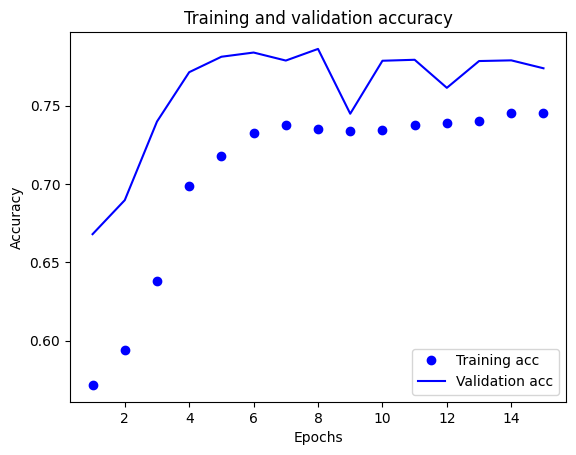

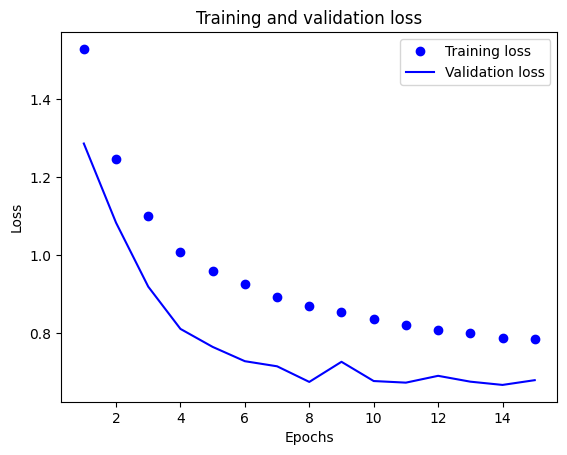

In [ ]:
model.save('/content/drive/MyDrive/assg/text_model_1.h5')
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Model 2 (Added Bidirectional LSTM)

In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words, output_dim=100))
model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.005)))) #added bidirectional
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.005)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,035,139 (3.95 MB)

 Trainable params: 1,035,139 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - acc: 0.4227 - loss: 2.1034 - val_acc: 0.6195 - val_loss: 1.5145
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - acc: 0.5348 - loss: 1.4619 - val_acc: 0.6831 - val_loss: 1.1658
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.5993 - loss: 1.1743 - val_acc: 0.7579 - val_loss: 0.9311
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - acc: 0.6806 - loss: 1.0193 - val_acc: 0.7687 - val_loss: 0.8341
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - acc: 0.7138 - loss: 0.9559 - val_acc: 0.7799 - val_loss: 0.7870
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - acc: 0.7323 - loss: 0.9164 - val_acc: 0.7812 - val_loss: 0.7668
Epoch 7/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - acc: 0.7432 - loss: 0.8891 - val_acc: 0.7800 - val_loss: 0.7449
Epoch 8/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - acc: 0.7497 - loss: 0.8685 - val_acc: 0.7806 - val_loss: 0.7286
Epoch 9/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 16

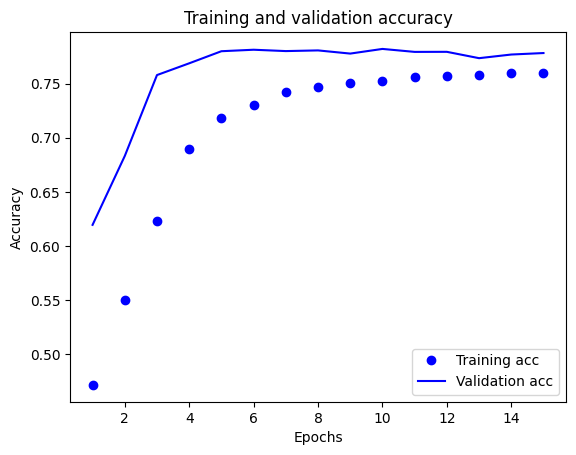

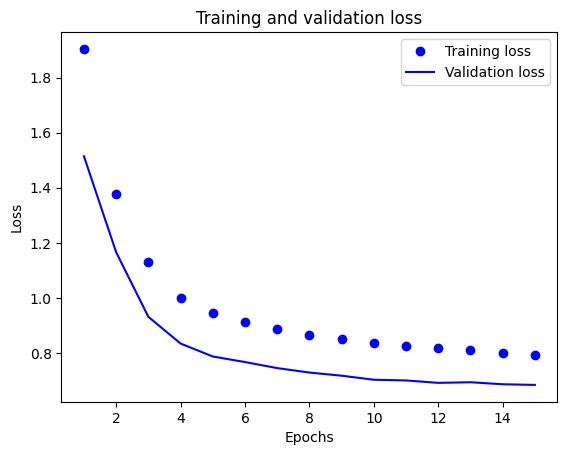

In [ ]:
model.save('/content/drive/MyDrive/assg/text_model_2.h5')
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Bidirectional works better hence we will stick with using Bidirectional

## Model 3 (Reduced regularization and dropout, increase number of units)

In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words, output_dim=100))
model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.003)))) #reduced regularization (0.005-> 0.003)
model.add(Dropout(0.3)) #reduced dropout rate (0.5->0.3)
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.003))) #reduced regularization (0.005-> 0.003), increased number of units (16-> 32)
model.add(Dropout(0.3)) #reduced dropout rate (0.5->0.3)
model.add(Dense(3, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,036,227 (3.95 MB)

 Trainable params: 1,036,227 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - acc: 0.4286 - loss: 1.7356 - val_acc: 0.6893 - val_loss: 1.3046
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.6615 - loss: 1.2764 - val_acc: 0.7647 - val_loss: 0.9502
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - acc: 0.7519 - loss: 1.0243 - val_acc: 0.7680 - val_loss: 0.8337
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - acc: 0.7657 - loss: 0.9262 - val_acc: 0.7743 - val_loss: 0.7710
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - acc: 0.7728 - loss: 0.8701 - val_acc: 0.7730 - val_loss: 0.7364
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - acc: 0.7698 - loss: 0.8384 - val_acc: 0.7786 - val_loss: 0.7112
Epoch 7/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - acc: 0.7790 - loss: 0.8122 - val_acc: 0.7839 - val_loss: 0.6928
Epoch 8/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.7767 - loss: 0.7964 - val_acc: 0.7822 - val_loss: 0.6848
Epoch 9/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 

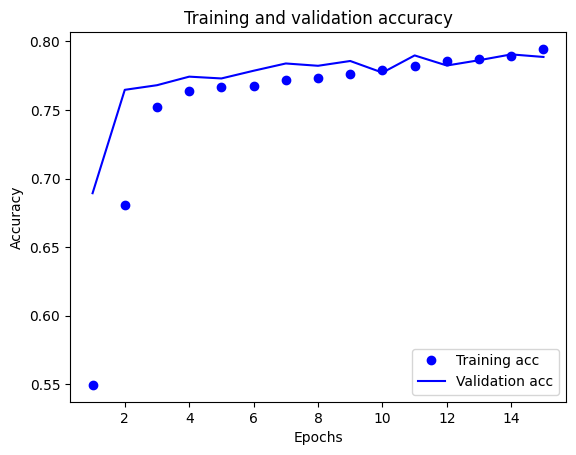

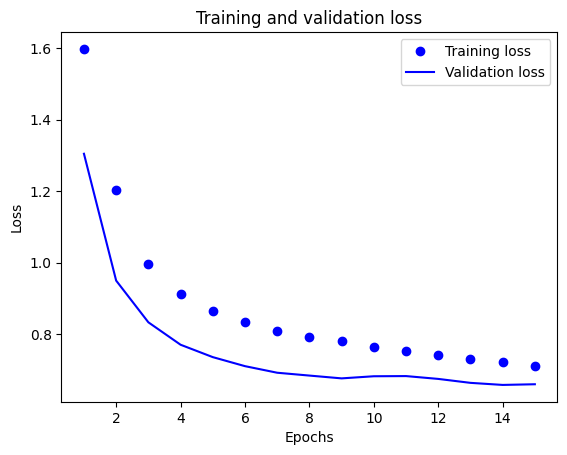

In [ ]:
model.save('/content/drive/MyDrive/assg/text_model_3.h5')
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Model 4 (Reduced regularization and dropout)

In [ ]:
model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words, output_dim=100))
model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.002)))) #further decreased regularization size  (0.003->0.002)
model.add(Dropout(0.2)) #further decreased dropout size  (0.3->0.2)
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.002))) #further decreased regularization size (0.003->0.002)
model.add(Dropout(0.2)) #further decreased dropout size (0.3->0.2)
model.add(Dense(3, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,036,227 (3.95 MB)

 Trainable params: 1,036,227 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - acc: 0.6187 - loss: 1.5052 - val_acc: 0.6932 - val_loss: 1.1378
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.7119 - loss: 1.1320 - val_acc: 0.7754 - val_loss: 0.8497
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - acc: 0.7620 - loss: 0.9556 - val_acc: 0.7800 - val_loss: 0.7596
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - acc: 0.7681 - loss: 0.8788 - val_acc: 0.7812 - val_loss: 0.7199
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - acc: 0.7711 - loss: 0.8344 - val_acc: 0.7754 - val_loss: 0.7055
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - acc: 0.7736 - loss: 0.8101 - val_acc: 0.7786 - val_loss: 0.6935
Epoch 7/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - acc: 0.7752 - loss: 0.7900 - val_acc: 0.7803 - val_loss: 0.6794
Epoch 8/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.7804 - loss: 0.7688 - val_acc: 0.7844 - val_loss: 0.6696
Epoch 9/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s

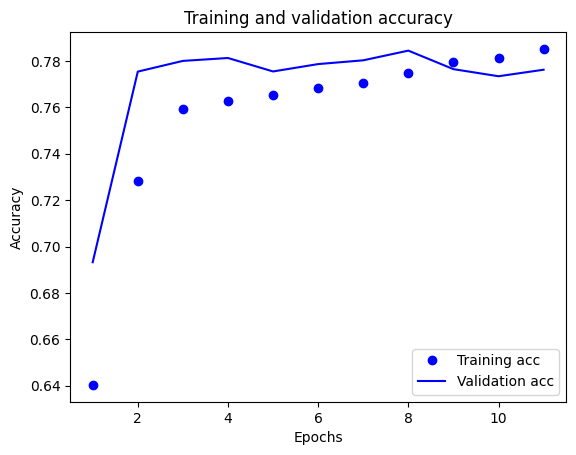

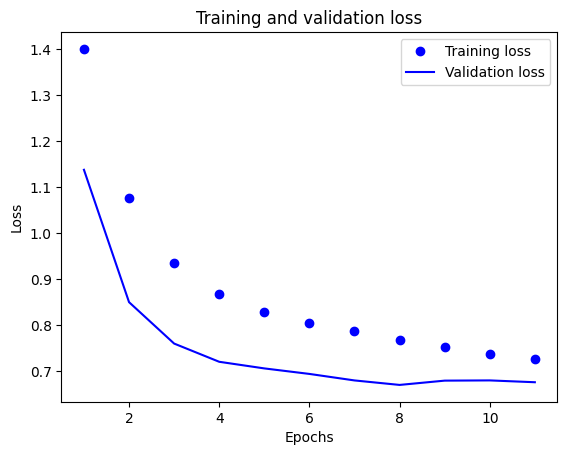

In [ ]:
model.save('/content/drive/MyDrive/assg/text_model_4.h5')
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Model 5 (Increased number of units)

In [ ]:
model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words, output_dim=100))
model.add(Bidirectional(LSTM(48, kernel_regularizer=l2(0.002)))) #increased number of units (32->48)
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 96)             │        57,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,060,419 (4.05 MB)

 Trainable params: 1,060,419 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 59s 21ms/step - acc: 0.5337 - loss: 1.5643 - val_acc: 0.6660 - val_loss: 1.1833
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - acc: 0.6476 - loss: 1.1728 - val_acc: 0.7808 - val_loss: 0.8844
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.7490 - loss: 0.9639 - val_acc: 0.7845 - val_loss: 0.7698
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - acc: 0.7670 - loss: 0.8770 - val_acc: 0.7754 - val_loss: 0.7297
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - acc: 0.7699 - loss: 0.8354 - val_acc: 0.7832 - val_loss: 0.6936
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - acc: 0.7708 - loss: 0.8077 - val_acc: 0.7814 - val_loss: 0.6878
Epoch 7/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - acc: 0.7768 - loss: 0.7849 - val_acc: 0.7891 - val_loss: 0.6710
Epoch 8/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - acc: 0.7766 - loss: 0.7680 - val_acc: 0.7937 - val_loss: 0.6544
Epoch 9/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 2

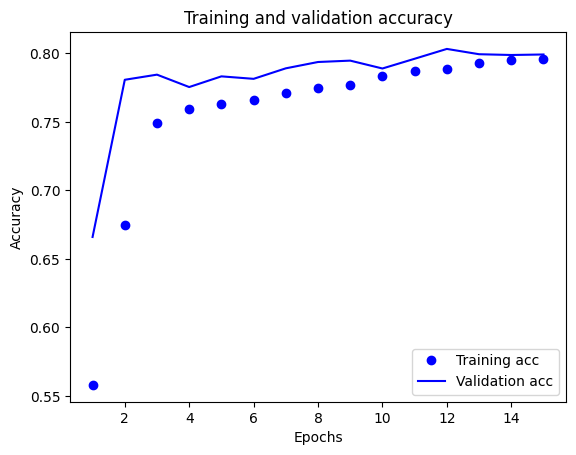

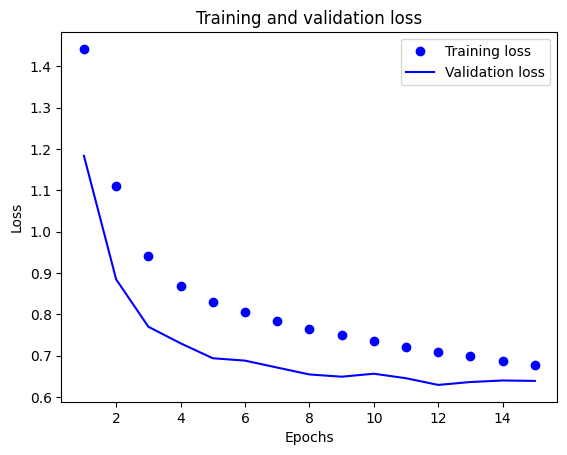

In [ ]:
model.save('/content/drive/MyDrive/assg/text_model_5.h5')
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Model 6 (Increased dropout, reduced learning rate)

In [ ]:
model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words, output_dim=100))
model.add(Bidirectional(LSTM(48, kernel_regularizer=l2(0.002))))
model.add(Dropout(0.25))  #increased dropout (0.2->0.25)
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(0.25)) #increased dropout (0.2->0.25)
model.add(Dense(3, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=5e-5), #reduced learning rate (1e-4 -> 5e-5)
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 96)             │        57,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,060,419 (4.05 MB)

 Trainable params: 1,060,419 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - acc: 0.4975 - loss: 1.6386 - val_acc: 0.3966 - val_loss: 1.3851
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.5172 - loss: 1.3761 - val_acc: 0.4812 - val_loss: 1.2217
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.5727 - loss: 1.2346 - val_acc: 0.6269 - val_loss: 1.0720
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - acc: 0.6358 - loss: 1.1115 - val_acc: 0.7125 - val_loss: 0.9310
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - acc: 0.7027 - loss: 1.0114 - val_acc: 0.7404 - val_loss: 0.8629
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - acc: 0.7322 - loss: 0.9585 - val_acc: 0.7526 - val_loss: 0.8213
Epoch 7/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - acc: 0.7476 - loss: 0.9174 - val_acc: 0.7562 - val_loss: 0.7949
Epoch 8/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - acc: 0.7567 - loss: 0.8875 - val_acc: 0.7684 - val_loss: 0.7629
Epoch 9/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 1

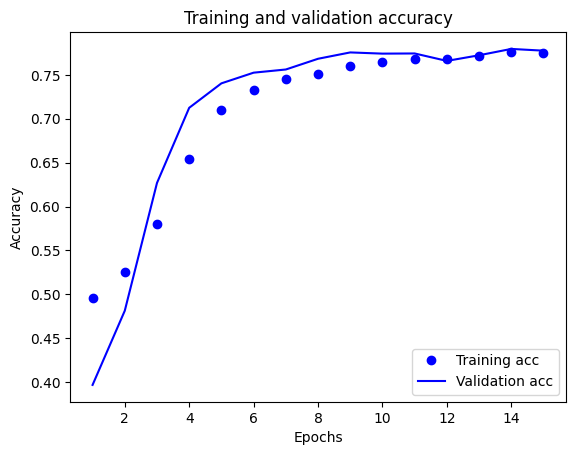

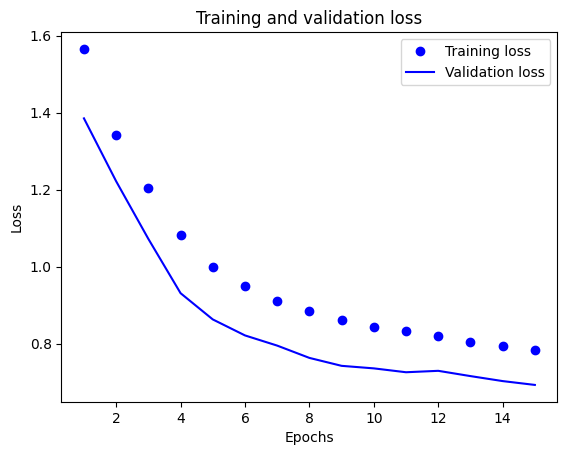

In [ ]:
model.save('/content/drive/MyDrive/assg/text_model_6.h5')
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Since Adam is still better than Nadam, we will stick with Adam

## Model 7 (Reduced dropout)

In [ ]:
model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words, output_dim=100))
model.add(Bidirectional(LSTM(48, kernel_regularizer=l2(0.002))))
model.add(Dropout(0.2)) #tuned dropout back down (0.25->0.2)
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(0.2)) #tuned dropout back down (0.25->0.2)
model.add(Dense(3, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 96)             │        57,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,060,419 (4.05 MB)

 Trainable params: 1,060,419 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - acc: 0.5461 - loss: 1.6356 - val_acc: 0.6579 - val_loss: 1.3646
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - acc: 0.6153 - loss: 1.3635 - val_acc: 0.6611 - val_loss: 1.1957
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - acc: 0.6364 - loss: 1.2084 - val_acc: 0.7133 - val_loss: 1.0103
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - acc: 0.7253 - loss: 1.0669 - val_acc: 0.7465 - val_loss: 0.8906
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.7516 - loss: 0.9799 - val_acc: 0.7553 - val_loss: 0.8331
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - acc: 0.7671 - loss: 0.9251 - val_acc: 0.7622 - val_loss: 0.7958
Epoch 7/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - acc: 0.7654 - loss: 0.8862 - val_acc: 0.7730 - val_loss: 0.7577
Epoch 8/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - acc: 0.7718 - loss: 0.8606 - val_acc: 0.7803 - val_loss: 0.7349
Epoch 9/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 

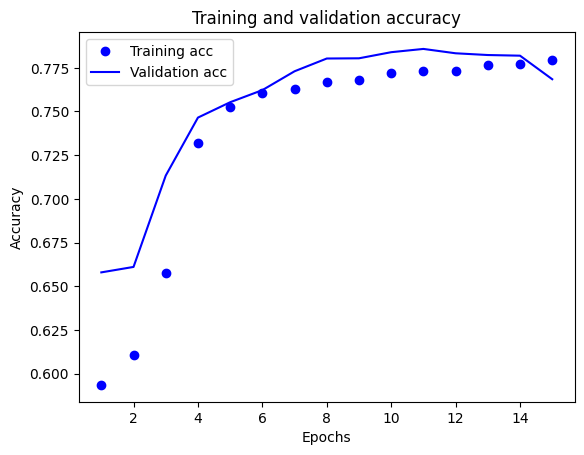

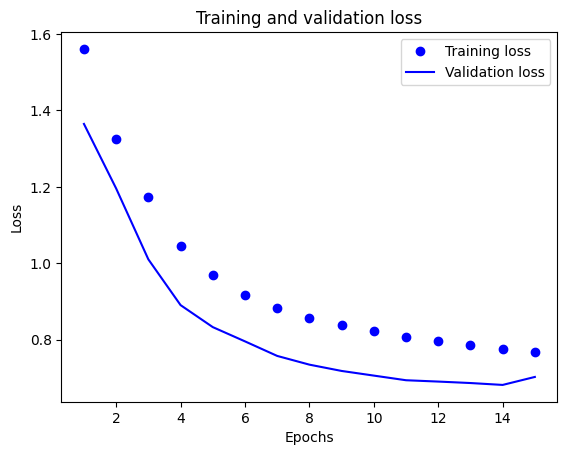

In [ ]:
model.save('/content/drive/MyDrive/assg/text_model_7.h5')
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Model 8 (Increased learning rate)


In [ ]:
model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words, output_dim=100))
model.add(Bidirectional(LSTM(48, kernel_regularizer=l2(0.002))))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=1e-4), # restore learning rate back to (5e-5->1e-4)
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 96)             │        57,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,060,419 (4.05 MB)

 Trainable params: 1,060,419 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - acc: 0.5476 - loss: 1.5491 - val_acc: 0.6892 - val_loss: 1.1884
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.6304 - loss: 1.1886 - val_acc: 0.7450 - val_loss: 0.9119
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - acc: 0.7205 - loss: 0.9861 - val_acc: 0.7571 - val_loss: 0.8048
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - acc: 0.7487 - loss: 0.9029 - val_acc: 0.7788 - val_loss: 0.7341
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - acc: 0.7618 - loss: 0.8449 - val_acc: 0.7794 - val_loss: 0.7012
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - acc: 0.7632 - loss: 0.8133 - val_acc: 0.7842 - val_loss: 0.6786
Epoch 7/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - acc: 0.7641 - loss: 0.7939 - val_acc: 0.7774 - val_loss: 0.6835
Epoch 8/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - acc: 0.7736 - loss: 0.7743 - val_acc: 0.7786 - val_loss: 0.6784
Epoch 9/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 1

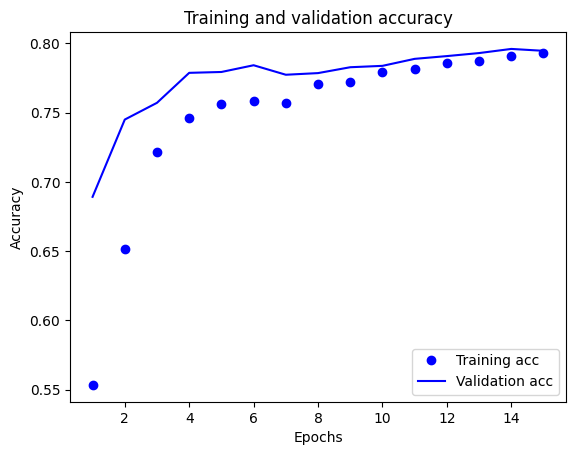

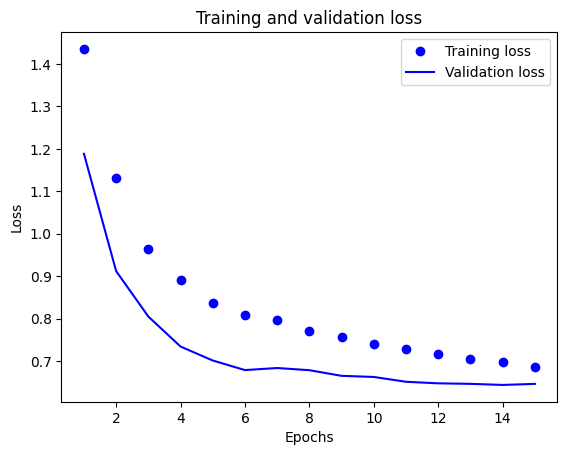

In [ ]:
model.save('/content/drive/MyDrive/assg/text_model_8.h5')
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Step 3 – Evaluate the Model using Testing Data (Individual & Group)

## Model 1

In [ ]:
# Model #1 (replicate where necessary for other models)
from tensorflow.keras.models import load_model
model1 = load_model('/content/drive/MyDrive/assg/text_model_1.h5')
model1.evaluate(X_test, y_test)

627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - acc: 0.7791 - loss: 0.6507


[0.6641501188278198, 0.7736526727676392]

## Model 2

In [ ]:
model2 = load_model('/content/drive/MyDrive/assg/text_model_2.h5')
model2.evaluate(X_test, y_test)

627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - acc: 0.7837 - loss: 0.6687


[0.6822780966758728, 0.776297390460968]

## Model 3

In [ ]:
model3 = load_model('/content/drive/MyDrive/assg/text_model_3.h5')
model3.evaluate(X_test, y_test)

627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.7949 - loss: 0.6410


[0.6567803025245667, 0.787574827671051]

## Model 4

In [ ]:
model4 = load_model('/content/drive/MyDrive/assg/text_model_4.h5')
model4.evaluate(X_test, y_test)

627/627 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.7885 - loss: 0.6527


[0.6692750453948975, 0.7826846241950989]

## Model 5

In [ ]:
model5 = load_model('/content/drive/MyDrive/assg/text_model_5.h5')
model5.evaluate(X_test, y_test)

627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.8056 - loss: 0.6118


[0.6268953084945679, 0.8006486892700195]

## Model 6

In [ ]:
model6 = load_model('/content/drive/MyDrive/assg/text_model_6.h5')
model6.evaluate(X_test, y_test)

627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - acc: 0.7786 - loss: 0.6782


[0.6941030025482178, 0.7720059752464294]

## Model 7

In [ ]:
model7 = load_model('/content/drive/MyDrive/assg/text_model_7.h5')
model7.evaluate(X_test, y_test)

627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.7891 - loss: 0.6678


[0.6835125684738159, 0.7810379266738892]

## Model 8

In [ ]:
model8 = load_model('/content/drive/MyDrive/assg/text_model_8.h5')
model8.evaluate(X_test, y_test)

627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.7978 - loss: 0.6239


[0.6419299244880676, 0.7918662428855896]

## Model 9

In [ ]:
# show the model output using predict function
from tensorflow.keras.models import load_model
model5 = load_model('/content/drive/MyDrive/assg/text_model_5.h5')
